https://ai.stanford.edu/~amaas/data/sentiment/

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
import glob
import os
import pandas as pd
import re
import requests
import tarfile

from tqdm import tqdm


import matplotlib.pyplot as plt

# Load data

In [ ]:
def get_data():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    filename = "aclImdb_v1.tar.gz"
    
    print("Downloading file...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(filename, 'wb') as file, tqdm(
            desc=filename,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    
    print("Extracting file...")
    if os.path.exists("aclImdb"):
        shutil.rmtree("aclImdb")
    with tarfile.open(filename) as tar:
        tar.extractall(filter='data')

    print("Renaming folder...")
    if os.path.exists("data/raw"): 
        shutil.rmtree("data/raw")
    if not os.path.exists("data"):
        os.makedirs("data")
    os.rename("aclImdb", "data/raw")
    
    print("Cleaning up...")
    os.remove(filename)
    
    print("Done! The dataset is now available in the 'data/raw' folder.")

if __name__ == "__main__":
    get_data()

In [ ]:
def process_data(base_dir):
    """
    Load IMDB dataset from directory structure:
    base_dir/
        train/
            pos/
                [id]_[rating].txt
            neg/
                [id]_[rating].txt
            unsup/
                [id]_0.txt
        test/
            pos/
                [id]_[rating].txt
            neg/
                [id]_[rating].txt
    
    Returns:
        train, test, unsup: pandas DataFrames
        - labeled data in train and test
        - unlabeled data in unsup
    """
    train_data = []
    test_data = []
    unsup_data = []
    
    # Process both train and test splits
    for split in ['train', 'test']:
        split_path = os.path.join(base_dir, split)
            
        # Process positive and negative reviews
        for sentiment in ['pos', 'neg']:
            sentiment_path = os.path.join(split_path, sentiment)
            sentiment_label = 'positive' if sentiment == 'pos' else 'negative'
            
            # Skip if directory doesn't exist
            if not os.path.exists(sentiment_path):
                print(f"Warning: {sentiment_path} does not exist")
                continue
                
            # Find all text files
            files = glob.glob(os.path.join(sentiment_path, '*.txt'))
            
            for file_path in files:
                # Extract id and rating from filename
                filename = os.path.basename(file_path)
                match = re.match(r'(\d+)_(\d+)\.txt', filename)
                
                if match:
                    review_id, rating = match.groups()
                    
                    # Read the review text
                    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                        text = f.read().strip()
                    
                    # Add to appropriate list based on split
                    entry = {
                        'id': int(review_id),
                        'text': text,
                        'sentiment': sentiment_label,
                        'rating': int(rating)
                    }
                    
                    if split == 'train':
                        train_data.append(entry)
                    else:
                        test_data.append(entry)
        
        # Process unsupervised data in train split)
        if split == 'train':
            unsup_path = os.path.join(split_path, 'unsup')
            files = glob.glob(os.path.join(unsup_path, '*.txt'))
                
            for file_path in files:
                # Extract id from filename
                filename = os.path.basename(file_path)
                match = re.match(r'(\d+)_0\.txt', filename)
                    
                if match:
                    review_id = match.groups()[0]
                        
                    # Read the review text
                    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                        text = f.read().strip()
                        
                    # Add to unsupervised data list
                    unsup_data.append({
                        'id': int(review_id),
                        'text': text
                    })
    
    # Convert lists to DataFrames
    train = pd.DataFrame(train_data)
    test = pd.DataFrame(test_data)
    unsup = pd.DataFrame(unsup_data)
    
    return train, test, unsup

train, test, unsup = process_data("data/raw/")

os.makedirs("data/processed/", exist_ok=True)
train.to_csv("data/processed/train.csv", index=False)
test.to_csv("data/processed/test.csv", index=False)
unsup.to_csv("data/processed/unsup.csv", index=False)

In [21]:
# Check that data is correctly loaded
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Unsupervised data shape: {unsup.shape}")

print("\nTrain data:")
print(train.head(2))
print("\n")
print("\nTest data sample:")
print(test.head(2))
print("\n")
print("\nUnsupervised data sample:")
print(unsup.head(2))

Train data shape: (25000, 4)
Test data shape: (25000, 4)
Unsupervised data shape: (50000, 2)

Train data:
      id                                               text sentiment  rating
0   4715  For a movie that gets no respect there sure ar...  positive       9
1  12390  Bizarre horror movie filled with famous faces ...  positive       8



Test data sample:
     id                                               text sentiment  rating
0  4715  Based on an actual story, John Boorman shows t...  positive       9
1  1930  This is a gem. As a Film Four production - the...  positive       9



Unsupervised data sample:
      id                                               text
0  18512  A newspaperman (Johnny Twennies) living in the...
1  37594  As co-founder of Nicko & Joe's Bad Film Club S...


# Description

In [4]:
train = pd.read_csv("data/processed/train.csv")
test = pd.read_csv("data/processed/test.csv")

## Ratings

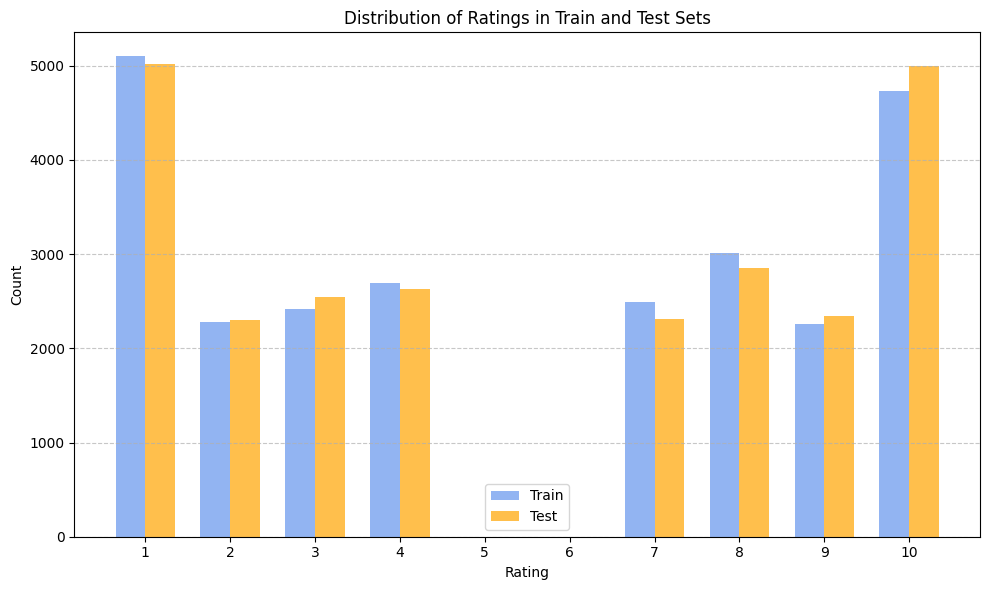

In [14]:
plt.figure(figsize=(10, 6))

ratings_range = range(1, 11)
x = np.array(ratings_range)
width = 0.35

train_counts = [train['rating'].value_counts().get(i, 0) for i in ratings_range]
test_counts = [test['rating'].value_counts().get(i, 0) for i in ratings_range]

plt.bar(x - width/2, train_counts, width, color='cornflowerblue', alpha=0.7, label='Train')
plt.bar(x + width/2, test_counts, width, color='orange', alpha=0.7, label='Test')

plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Distribution of Ratings in Train and Test Sets')
plt.xticks(ratings_range)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Length

In [6]:
def get_text_stats(df):
    # Character length
    df['char_length'] = df['text'].apply(len)
    char_min = df['char_length'].min()
    char_max = df['char_length'].max()
    char_avg = df['char_length'].mean()
    
    # Word length
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    word_min = df['word_count'].min()
    word_max = df['word_count'].max()
    word_avg = df['word_count'].mean()
    
    return {
        'char_min': char_min,
        'char_max': char_max,
        'char_avg': round(char_avg, 0),
        'word_min': word_min,
        'word_max': word_max,
        'word_avg': round(word_avg, 0)
    }

train_stats = get_text_stats(train)
test_stats = get_text_stats(test)

# Create a comparison dataframe
comparison = pd.DataFrame({
    'Train': [train_stats['char_min'],
              train_stats['char_max'],
              train_stats['char_avg'],
              train_stats['word_min'],
              train_stats['word_max'],
              train_stats['word_avg']],
    'Test': [test_stats['char_min'],
             test_stats['char_max'],
             test_stats['char_avg'],
             test_stats['word_min'],
             test_stats['word_max'],
             test_stats['word_avg']]}, 
    index=['Min Characters',
          'Max Characters',
          'Avg Characters',
          'Min Words',
          'Max Words',
          'Avg Words'])

comparison.style.set_caption('Text Length Statistics').format("{:.0f}")

,Train,Test
Min Characters,52,32
Max Characters,13704,12988
Avg Characters,1325,1294
Min Words,10,4
Max Words,2470,2278
Avg Words,234,229


## Emojis

In [ ]:
pip install emoji

In [23]:
import emoji
from collections import Counter

# Count samples with emojis
train['has_emoji'] = train['text'].apply(lambda x: emoji.emoji_count(x) > 0)
train_emoji_count = train['has_emoji'].sum()
train_total = len(train)
train_percentage = (train_emoji_count / train_total) * 100

test['has_emoji'] = test['text'].apply(lambda x: emoji.emoji_count(x) > 0)
test_emoji_count = test['has_emoji'].sum()
test_total = len(test)
test_percentage = (test_emoji_count / test_total) * 100

print(f"Train set: {train_emoji_count} out of {train_total} samples contain emojis ({train_percentage:.2f}%)")
print(f"Test set: {test_emoji_count} out of {test_total} samples contain emojis ({test_percentage:.2f}%)")

# Get most common emojis
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

all_train_emojis = ''.join(train['text'].apply(extract_emojis))
train_emoji_counts = Counter(all_train_emojis)

all_test_emojis = ''.join(test['text'].apply(extract_emojis))
test_emoji_counts = Counter(all_test_emojis)

print("\nMost common emojis in train set:")
for em, count in train_emoji_counts.most_common(10):
    print(f"{em} ({count})")

print("\nMost common emojis in test set:")
for em, count in test_emoji_counts.most_common(10):
    print(f"{em} ({count})")

Train set: 4 out of 25000 samples contain emojis (0.02%)
Test set: 1 out of 25000 samples contain emojis (0.00%)

Most common emojis in train set:
® (4)

Most common emojis in test set:
© (1)


## HTML markup

In [28]:
def contains_html_tags(text):
    pattern = re.compile(r'<[^>]+>')
    return bool(pattern.search(str(text)))

train['has_html'] = train['text'].apply(contains_html_tags)
test['has_html'] = test['text'].apply(contains_html_tags)

train_html_count = train['has_html'].sum()
train_total_count = len(train)
train_percentage = (train_html_count / train_total_count) * 100

test_html_count = test['has_html'].sum()
test_total_count = len(test)
test_percentage = (test_html_count / test_total_count) * 100

print(f"Reviews containing HTML markup in train: {train_html_count} out of {train_total_count} ({train_percentage:.2f}%)")
print(f"Reviews containing HTML markup in test: {test_html_count} out of {train_total_count} ({test_percentage:.2f}%)")

def extract_html_tags(text):
    pattern = re.compile(r'<([a-zA-Z][a-zA-Z0-9]*)')
    matches = pattern.findall(str(text))
    return matches

if html_count > 0:
    all_tags = []
    for text in train[train['has_html']]['text']:
        tags = extract_html_tags(text)
        all_tags.extend(tags)

    for text in test[test['has_html']]['text']:
        tags = extract_html_tags(text)
        all_tags.extend(tags)
    
    tag_counts = Counter(all_tags)
    
    print("\nMost common HTML tags:")
    for tag, count in tag_counts.most_common(10):
        print(f"{tag} ({count})")

Reviews containing HTML markup in train: 14667 out of 25000 (58.67%)
Reviews containing HTML markup in test: 14535 out of 25000 (58.14%)

Most common HTML tags:
br (201948)
i (8)
grin (2)
SPOILER (1)
sigh (1)
em (1)
sp (1)
http (1)
hr (1)
p (1)


# Preprocessing

In [10]:
# Separating features and labels

# convert sentiment to binary?
X_train = train['text']
y_train = train['sentiment']

X_test = test['text']
y_test = test['sentiment'] 